In [28]:
import torch
import torchvision 
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import os

In [29]:
# 定义多头自注意力模块
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size=128, heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        # 确保嵌入维度可以被头数整除
        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        # 定义线性变换，用于计算 values, keys 和 queries
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]  # 获取 batch size
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # 将 values, keys 和 queries 进行 reshape，以便分头处理
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        # 通过线性变换得到新的 values, keys 和 queries
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # 计算注意力得分
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        # 计算注意力加权后的 values
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        # 通过全连接层输出
        out = self.fc_out(out)
        return out

class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        # 定义卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()

        # 定义注意力模块
        self.attention = MultiHeadSelfAttention(embed_size=64 * 7 * 7, heads=8)

        # 定义全连接层
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)  # 展平张量

        # 使用注意力机制
        x = x.unsqueeze(1)  # 增加一个维度，模拟序列数据
        x = self.attention(x, x, x)  # 使用自注意力
        x = x.squeeze(1)  # 移除多余的维度

        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [30]:
# 定义 MLP 模块
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 定义卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()

        # 定义全连接层
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)  # 修正输入维度
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)  # 展平张量
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [32]:
# 定义 RNN 模块
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [33]:
# 定义 ResNet 模块
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

In [34]:
# 设备选择
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 数据预处理
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

# 定义超参数 && 准备数据集   
BATCH_SIZE = 256
EPOCHS = 10
trainData = torchvision.datasets.MNIST('./data/', train=True, transform=transform, download=True)
testData = torchvision.datasets.MNIST('./data/', train=False, transform=transform)

trainDataLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=BATCH_SIZE)

=====================training CNN===========================


[1/10] Loss: 1.5885, Acc: 0.8646, Test Loss: 1.5906, Test Acc: 0.8529: 100%|██████████| 235/235 [00:18<00:00, 12.42step/s]
[2/10] Loss: 1.4614, Acc: 0.9792, Test Loss: 1.4883, Test Acc: 0.9515: 100%|██████████| 235/235 [00:18<00:00, 12.52step/s]
[3/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4781, Test Acc: 0.9606: 100%|██████████| 235/235 [00:18<00:00, 12.58step/s]
[4/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4753, Test Acc: 0.9635: 100%|██████████| 235/235 [00:18<00:00, 12.48step/s]
[5/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4742, Test Acc: 0.9646: 100%|██████████| 235/235 [00:19<00:00, 12.21step/s]
[6/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4733, Test Acc: 0.9648: 100%|██████████| 235/235 [00:19<00:00, 12.11step/s]
[7/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4797, Test Acc: 0.9586: 100%|██████████| 235/235 [00:19<00:00, 11.99step/s]
[8/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4725, Test Acc: 0.9660: 100%|██████████| 235/235 [00:19<00:00, 11.79step/s]
[9/10] Loss: 1.4

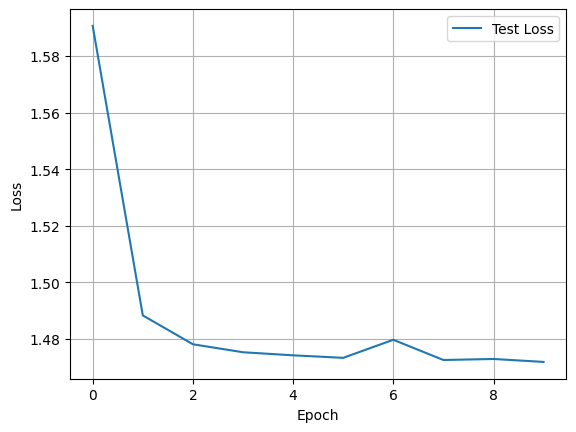

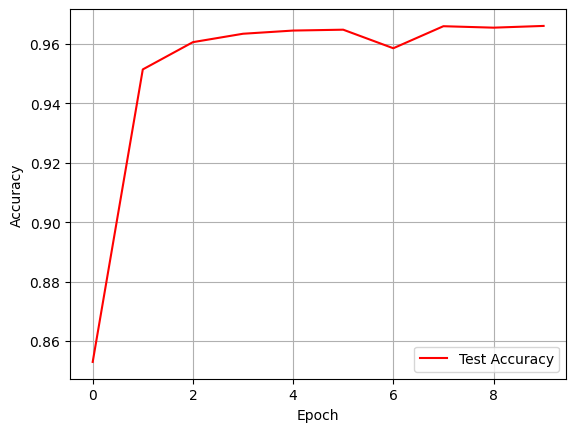

=====================training RNN===========================


[1/10] Loss: 0.0491, Acc: 0.9688, Test Loss: 0.1418, Test Acc: 0.9335: 100%|██████████| 235/235 [00:21<00:00, 10.82step/s]
[2/10] Loss: 0.0104, Acc: 0.9583, Test Loss: 0.0924, Test Acc: 0.9496: 100%|██████████| 235/235 [00:21<00:00, 11.02step/s]
[3/10] Loss: 0.0040, Acc: 0.9583, Test Loss: 0.0753, Test Acc: 0.9529: 100%|██████████| 235/235 [00:20<00:00, 11.31step/s]
[4/10] Loss: 0.0324, Acc: 0.9896, Test Loss: 0.0627, Test Acc: 0.9576: 100%|██████████| 235/235 [00:20<00:00, 11.40step/s]
[5/10] Loss: 0.0046, Acc: 0.9792, Test Loss: 0.0554, Test Acc: 0.9602: 100%|██████████| 235/235 [00:20<00:00, 11.71step/s]
[6/10] Loss: 0.0007, Acc: 0.9583, Test Loss: 0.0472, Test Acc: 0.9617: 100%|██████████| 235/235 [00:20<00:00, 11.72step/s]
[7/10] Loss: 0.0009, Acc: 1.0000, Test Loss: 0.0420, Test Acc: 0.9624: 100%|██████████| 235/235 [00:20<00:00, 11.71step/s]
[8/10] Loss: 0.0009, Acc: 0.9896, Test Loss: 0.0471, Test Acc: 0.9612: 100%|██████████| 235/235 [00:20<00:00, 11.66step/s]
[9/10] Loss: 0.0

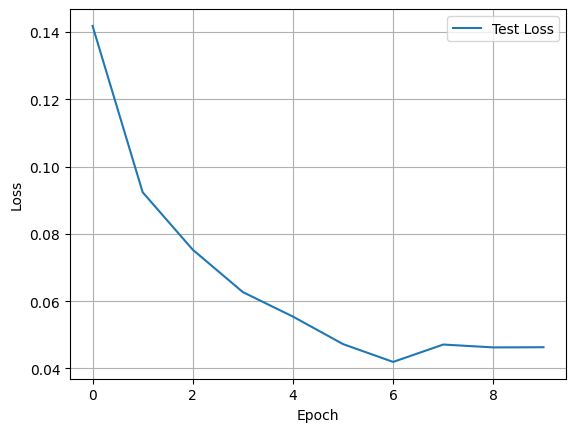

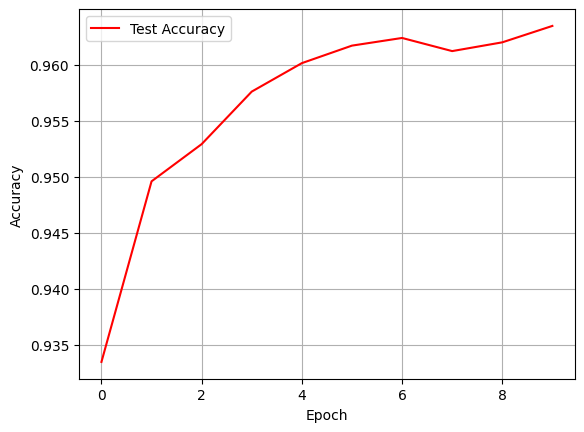

=====================training ResNet===========================


[1/10] Loss: 0.0010, Acc: 0.9688, Test Loss: 0.0636, Test Acc: 0.9567: 100%|██████████| 235/235 [04:18<00:00,  1.10s/step]
[2/10] Loss: 0.0009, Acc: 1.0000, Test Loss: 0.0569, Test Acc: 0.9595: 100%|██████████| 235/235 [04:13<00:00,  1.08s/step]
[3/10] Loss: 0.0001, Acc: 0.9896, Test Loss: 0.0370, Test Acc: 0.9661: 100%|██████████| 235/235 [04:14<00:00,  1.08s/step]
[4/10] Loss: 0.0048, Acc: 0.9896, Test Loss: 0.0439, Test Acc: 0.9626: 100%|██████████| 235/235 [04:15<00:00,  1.09s/step]
[5/10] Loss: 0.0001, Acc: 0.9896, Test Loss: 0.0333, Test Acc: 0.9657: 100%|██████████| 235/235 [04:23<00:00,  1.12s/step]
[6/10] Loss: 0.0000, Acc: 1.0000, Test Loss: 0.0340, Test Acc: 0.9661: 100%|██████████| 235/235 [04:09<00:00,  1.06s/step]
[7/10] Loss: 0.0002, Acc: 0.9896, Test Loss: 0.0370, Test Acc: 0.9657: 100%|██████████| 235/235 [04:00<00:00,  1.02s/step]
[8/10] Loss: 0.0001, Acc: 1.0000, Test Loss: 0.0269, Test Acc: 0.9682: 100%|██████████| 235/235 [04:00<00:00,  1.03s/step]
[9/10] Loss: 0.0

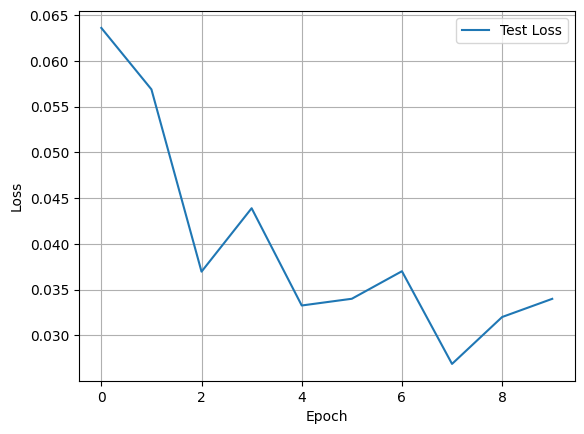

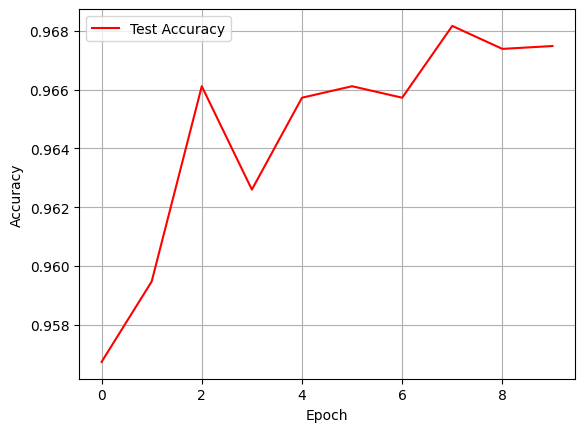

=====================training MLP===========================


[1/10] Loss: 0.0350, Acc: 0.9167, Test Loss: 0.2158, Test Acc: 0.9134: 100%|██████████| 235/235 [00:12<00:00, 19.19step/s]
[2/10] Loss: 0.0295, Acc: 0.9583, Test Loss: 0.1368, Test Acc: 0.9350: 100%|██████████| 235/235 [00:11<00:00, 19.67step/s]
[3/10] Loss: 0.0238, Acc: 0.9792, Test Loss: 0.1319, Test Acc: 0.9355: 100%|██████████| 235/235 [00:12<00:00, 19.41step/s]
[4/10] Loss: 0.0104, Acc: 0.9792, Test Loss: 0.0922, Test Acc: 0.9471: 100%|██████████| 235/235 [00:12<00:00, 19.27step/s]
[5/10] Loss: 0.0060, Acc: 0.9688, Test Loss: 0.0954, Test Acc: 0.9473: 100%|██████████| 235/235 [00:12<00:00, 19.46step/s]
[6/10] Loss: 0.0022, Acc: 0.9583, Test Loss: 0.0860, Test Acc: 0.9511: 100%|██████████| 235/235 [00:12<00:00, 18.92step/s]
[7/10] Loss: 0.0045, Acc: 0.9896, Test Loss: 0.0888, Test Acc: 0.9499: 100%|██████████| 235/235 [00:11<00:00, 19.71step/s]
[8/10] Loss: 0.0006, Acc: 0.9792, Test Loss: 0.0884, Test Acc: 0.9515: 100%|██████████| 235/235 [00:11<00:00, 19.80step/s]
[9/10] Loss: 0.0

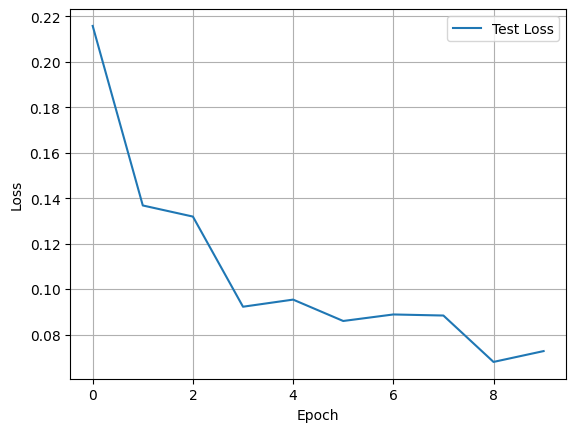

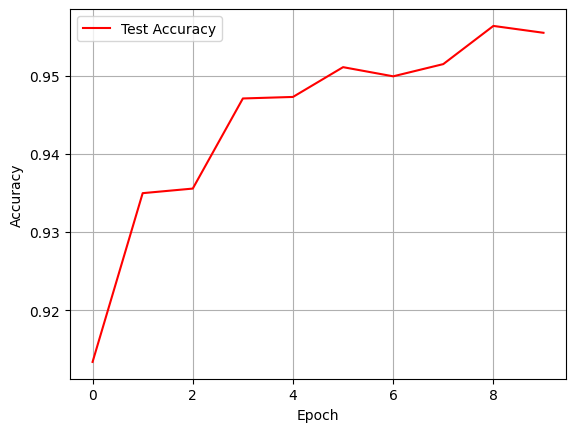

=====================training CNNWithAttention===========================


[1/10] Loss: 1.4612, Acc: 0.9688, Test Loss: 1.4925, Test Acc: 0.9459: 100%|██████████| 235/235 [00:42<00:00,  5.55step/s]
[2/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4870, Test Acc: 0.9502: 100%|██████████| 235/235 [00:43<00:00,  5.45step/s]
[3/10] Loss: 1.4612, Acc: 0.9479, Test Loss: 1.5008, Test Acc: 0.9362: 100%|██████████| 235/235 [00:40<00:00,  5.75step/s]
[4/10] Loss: 1.5237, Acc: 0.9167, Test Loss: 1.5002, Test Acc: 0.9388: 100%|██████████| 235/235 [00:40<00:00,  5.79step/s]
[5/10] Loss: 1.5655, Acc: 0.9062, Test Loss: 1.5685, Test Acc: 0.8713: 100%|██████████| 235/235 [00:40<00:00,  5.83step/s]
[6/10] Loss: 1.6487, Acc: 0.8333, Test Loss: 1.6496, Test Acc: 0.7924: 100%|██████████| 235/235 [00:40<00:00,  5.80step/s]
[7/10] Loss: 1.5862, Acc: 0.7604, Test Loss: 1.6630, Test Acc: 0.7776: 100%|██████████| 235/235 [00:40<00:00,  5.83step/s]
[8/10] Loss: 1.8362, Acc: 0.6354, Test Loss: 1.8362, Test Acc: 0.6104: 100%|██████████| 235/235 [00:40<00:00,  5.76step/s]
[9/10] Loss: 1.7

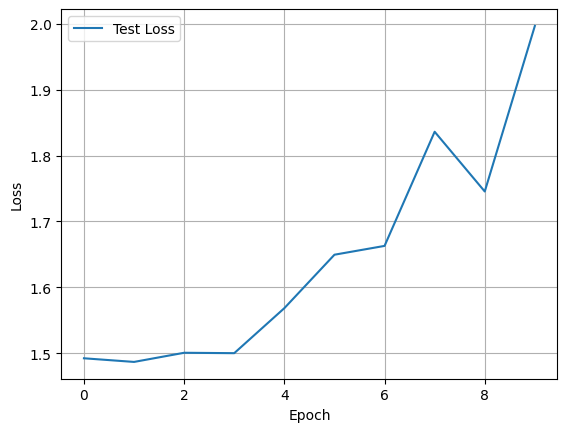

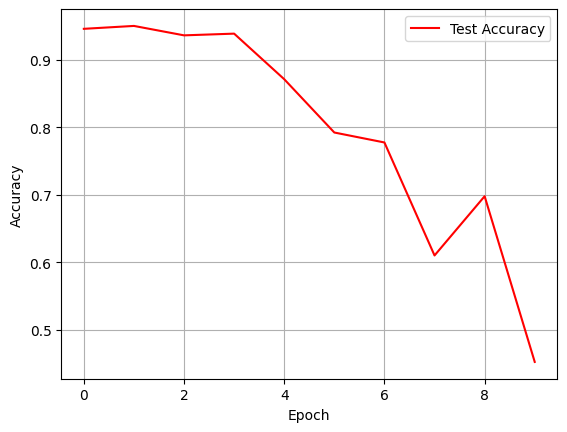

In [35]:
# 模型列表
modelList = {
    'CNN': CNN().to(device),
    'RNN': RNN().to(device),
    'ResNet': ResNet().to(device),
    'MLP': MLP().to(device),
    'CNNWithAttention': CNNWithAttention().to(device),
}


# 训练和测试
for modelName, model in modelList.items():
    lossF = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(model.parameters())  # Adam优化器
    history = {'Test Loss': [], 'Test Accuracy': []}  # 记录测试集损失和准确率
    print(f"=====================training {modelName}===========================")
    for epoch in range(1, EPOCHS + 1):
        # 训练集训练
        processBar = tqdm(trainDataLoader, unit='step')  # 进度条
        model.train(True)  # 训练模式
        for step, (trainImgs, labels) in enumerate(processBar):
            trainImgs = trainImgs.to(device)
            labels = labels.to(device)

            model.zero_grad()  # 梯度清零
            outputs = model(trainImgs)  # 前向传播
            loss = lossF(outputs, labels)  # 计算损失
            predictions = torch.argmax(outputs, dim=1)  # 获取预测结果
            accuracy = torch.sum(predictions == labels) / labels.shape[0]  # 计算准确率
            loss.backward()  # 反向传播

            optimizer.step()  # 更新参数
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" %
                                      (epoch, EPOCHS, loss.item(), accuracy.item()))

            # 测试集验证
            if step == len(processBar) - 1:
                correct, totalLoss = 0, 0
                model.train(False)  # 测试模式
                with torch.no_grad():  # 不计算梯度 优化性能
                    for testImgs, labels in testDataLoader:
                        testImgs = testImgs.to(device)
                        labels = labels.to(device)
                        outputs = model(testImgs)  # 前向传播
                        loss = lossF(outputs, labels)  # 计算损失
                        predictions = torch.argmax(outputs, dim=1)  # 获取预测结果

                        totalLoss += loss  # 累加损失
                        correct += torch.sum(predictions == labels)  # 累加正确预测数

                    testAccuracy = correct / (BATCH_SIZE * len(testDataLoader))  # 计算测试集准确率
                    testLoss = totalLoss / len(testDataLoader)  # 计算测试集平均损失
                    history['Test Loss'].append(testLoss.item())  # 记录测试集损失
                    history['Test Accuracy'].append(testAccuracy.item())  # 记录测试集准确率

                processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %
                                           (epoch, EPOCHS, loss.item(), accuracy.item(), testLoss.item(), testAccuracy.item()))
        processBar.close()  # 关闭进度条

    # 绘制损失和准确率曲线
    plt.plot(history['Test Loss'], label='Test Loss')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(history['Test Accuracy'], color='red', label='Test Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # 确保路径存在
    os.makedirs(os.path.dirname(f'./model-{modelName}.pth'), exist_ok=True)

    torch.save(model, f'./model-{modelName}.pth')  # 保存模型